In [1]:
%matplotlib nbagg
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from GCR import GCRQuery
import GCRCatalogs
import pyccl as ccl
from tophat_sed import GalaxyTopHatSEDFactory

In [2]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [3]:
component_type = 'bulge_no_host_extinction'

healpix = 9556
#healpix = 9683
#healpix = 9684

In [4]:
component = component_type.split('_')[0]

tophat_wls = []
tophat_cols = []
print(catalog._native_filter_quantities)
for item in sorted(catalog.list_all_quantities()):
    if item.startswith('sed') and item.endswith(component_type):
        tokens = item.split('_')
        tophat_wls.append(float(tokens[1]))
        tophat_cols.append(item)
index = np.argsort(tophat_wls)
tophat_wls = np.array(tophat_wls)[index]
tophat_cols = np.array(tophat_cols)[index]
#print(tophat_wls)
#print(tophat_cols)

{'redshift_block_lower', 'healpix_pixel'}


In [5]:
class MagNorm:
    def __init__(self, Omega_c=0.2648, Omega_b=0.0448, h=0.71, sigma8=0.8, n_s=0.963):
        self.cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s)
    def dl(self, z):
        aa = 1/(1 + z)
        return ccl.luminosity_distance(self.cosmo, aa)*ccl.physical_constants.MPC_TO_METER
    def __call__(self, tophat_sed_value, redshift_hubble, one_maggy=4.3442e13):
        one_Jy = 1e-26  # W/Hz/m**2
        Lnu = tophat_sed_value*one_maggy    # convert from maggies to W/Hz
        Fnu = Lnu/4/np.pi/self.dl(redshift_hubble)**2
        return -2.5*np.log10(Fnu/one_Jy) + 8.90

mag_norm = MagNorm(Omega_c=catalog.cosmology.Om0, Omega_b=catalog.cosmology.Ob0, h=catalog.cosmology.h,
                   sigma8=catalog.cosmology.sigma8, n_s=catalog.cosmology.n_s)

In [6]:
def compare_mag_norms(df, df_summary, sed_column=f'sed_4848_300_{component}_no_host_extinction',
                      one_maggy=4.3442e13, nsamp=None):
    if nsamp is None:
        nsamp = len(df_summary)
    mag_norm_values = []
    delta_mag_norm = []
    for _, galaxy_id, orig_magnorm in zip(range(nsamp), df_summary['gal_id'], df_summary['orig_magnorm']):
        row = df.query(f'galaxy_id == {galaxy_id}').iloc[0]
        mag_norm_values.append(mag_norm(row[sed_column], row['redshift_true'], one_maggy=one_maggy))
        delta_mag_norm.append(np.abs(orig_magnorm - mag_norm_values[-1]))
    return mag_norm_values, delta_mag_norm

In [7]:
def sed_file(orig_sed_file, sims_sed_library_dir=None):
    if sims_sed_library_dir is None:
        sims_sed_library_dir = ('/global/cfs/cdirs/descssim/DC2/sims_sed_library_dir')
    folder = os.path.basename(os.path.dirname(orig_sed_file))
    basename = os.path.basename(orig_sed_file)
    return os.path.join(sims_sed_library_dir, folder, basename)

In [8]:
def plot_tophat_sed(df_seds, galaxy_id, tophat_wls=tophat_wls, tophat_cols=tophat_cols):
    df = df_seds.query(f'galaxy_id=={galaxy_id}')
    tophat_Fnus = [df.iloc[0][_] for _ in tophat_cols]
    wl = [tophat_wls[0]]
    Fnu = []
    for wl_val, Fnu_val in zip(tophat_wls[1:], tophat_Fnus[:-1]):
        wl.extend((wl_val, wl_val))
        Fnu.extend((Fnu_val, Fnu_val))
    Fnu.append(tophat_Fnus[-1])
    wl = np.array(wl)
    Fnu = np.array(Fnu)
    plt.plot(wl, Fnu)
    return wl, Fnu

In [9]:
df_summary = pd.read_csv(f'jrb_example_dir/{component}_sed_hp{healpix}_summary.csv')
columns = ['galaxy_id', 'ra', 'dec', 'redshift', 'redshift_true'] + list(tophat_cols)
data = catalog.get_quantities(columns, native_filters=[f'healpix_pixel == {healpix}'])
df_seds = pd.DataFrame(data=data)

In [10]:
nsamp = None
%time tophat_mag_norm, delta_mag_norm = compare_mag_norms(df_seds, df_summary, nsamp=nsamp)
df_summary['tophat_mag_norm'] = tophat_mag_norm
df_summary['delta_mag_norm'] = delta_mag_norm

CPU times: user 7.59 s, sys: 8.35 s, total: 15.9 s
Wall time: 15.3 s


In [11]:
index = np.where(delta_mag_norm == max(delta_mag_norm))
worst_mag_norm = index[0][0]
print(index, delta_mag_norm[worst_mag_norm])

(array([26]),) 2.5967600334298098


<IPython.core.display.Javascript object>


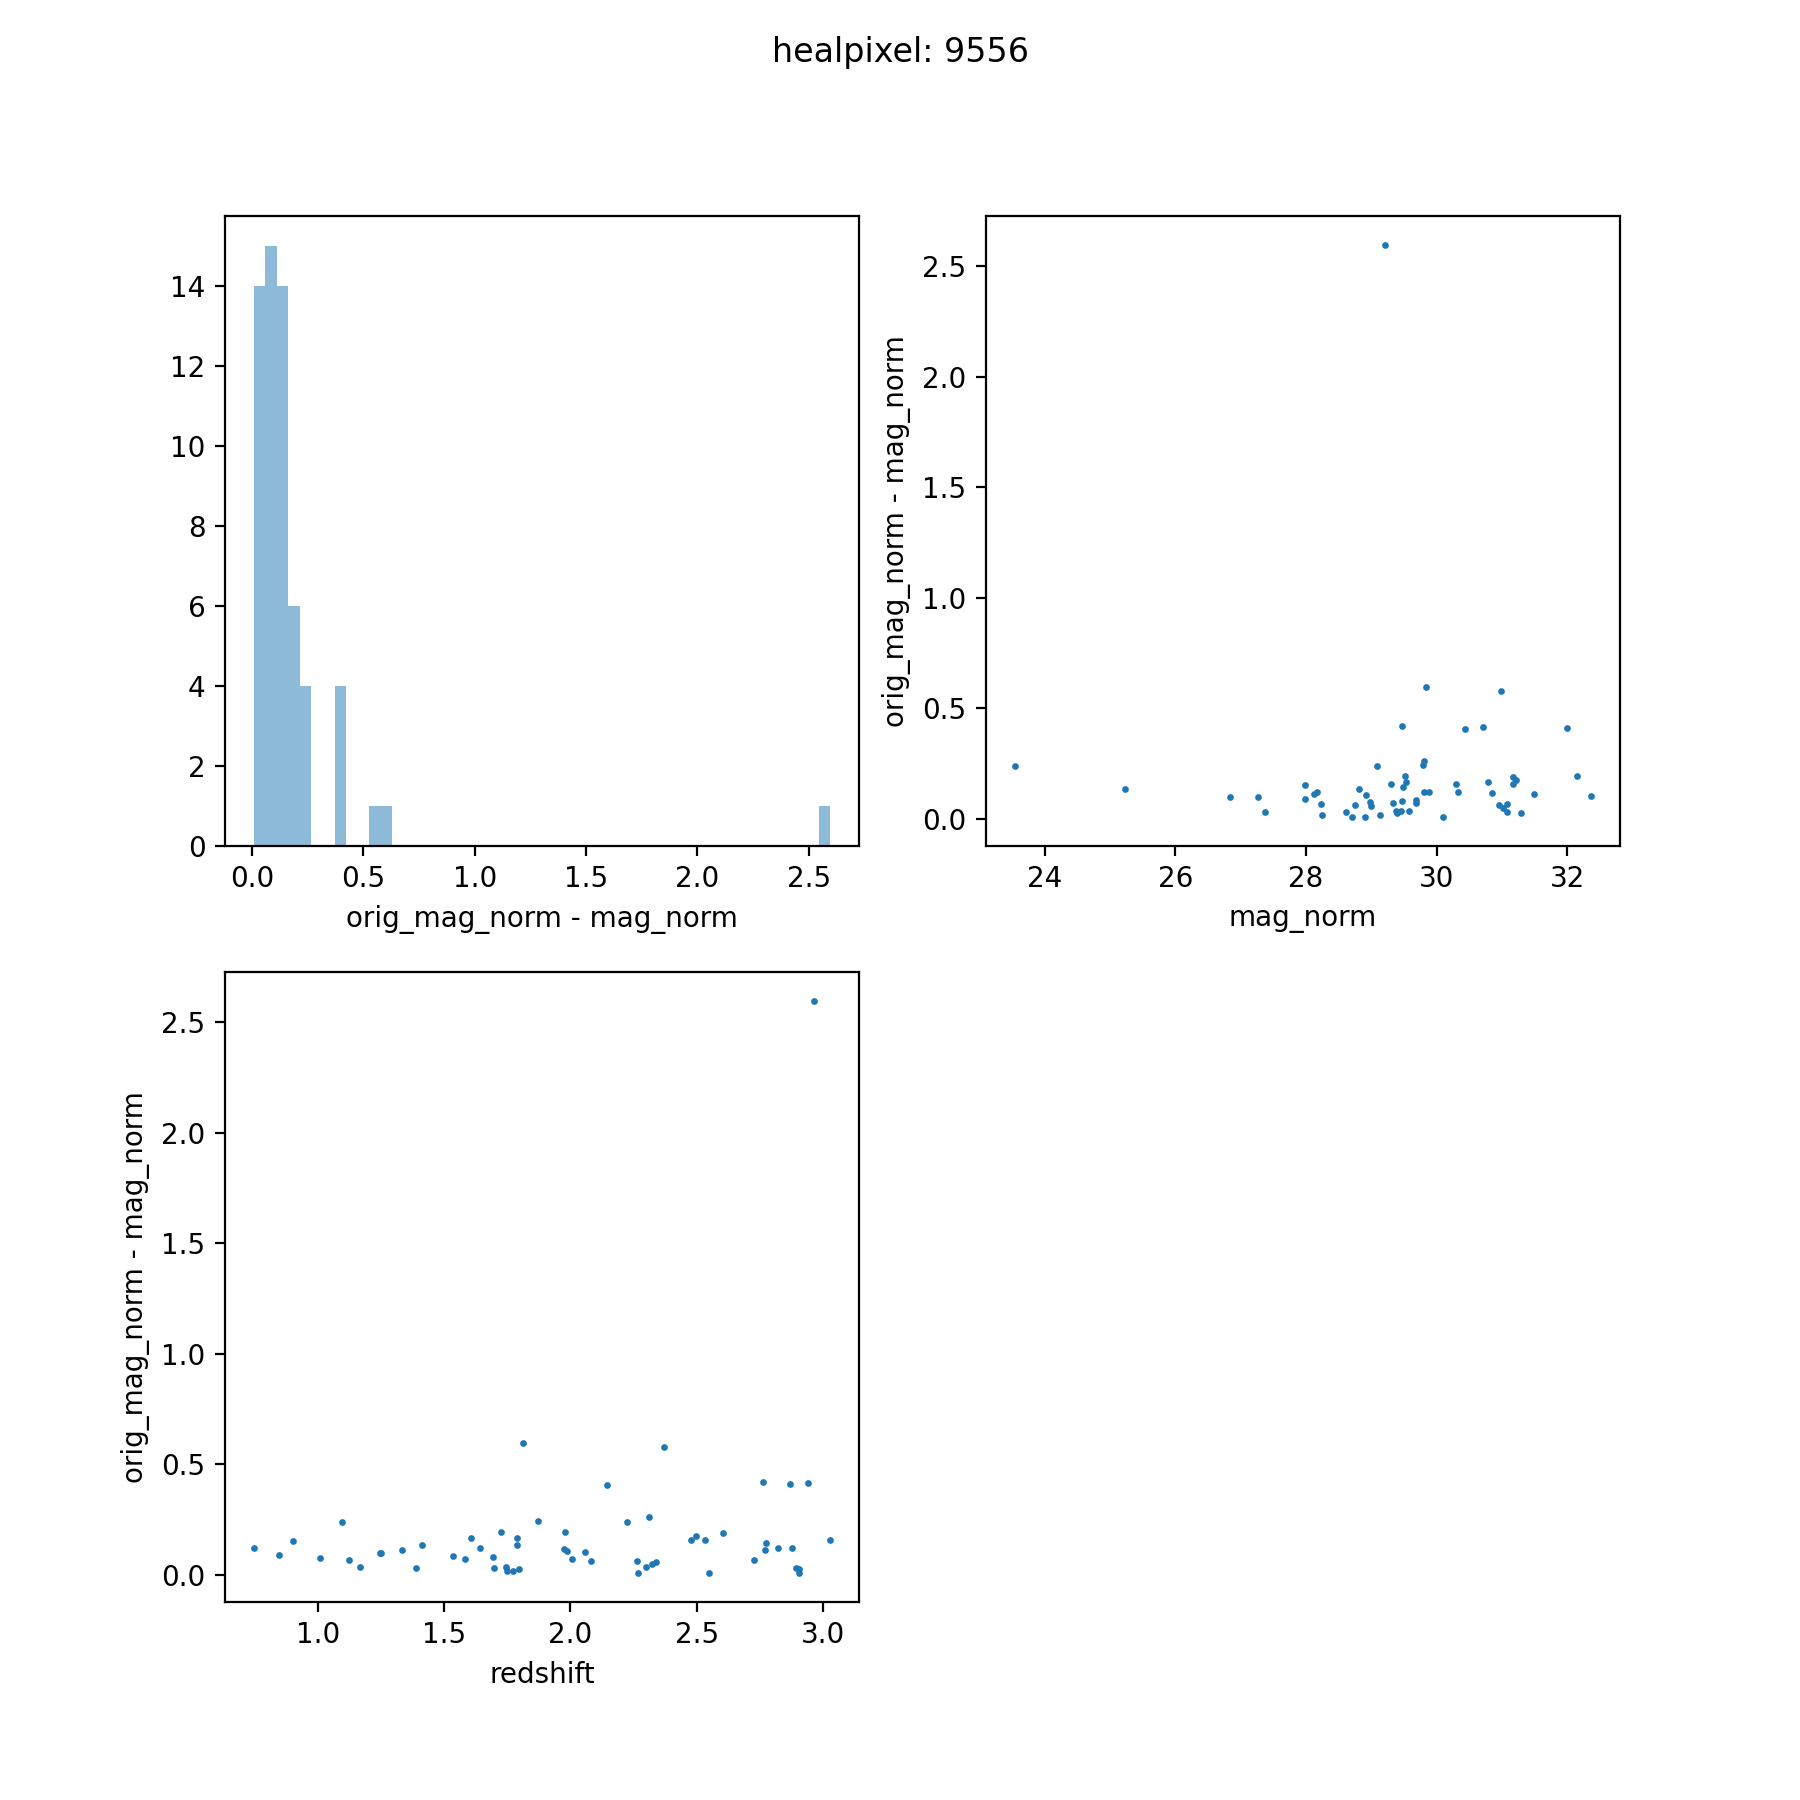

In [12]:
#%%script false --no-raise-error
plt.figure(figsize=(9, 9))
plt.subplot(2, 2, 1)
plt.hist(delta_mag_norm, bins=50, alpha=0.5)
plt.xlabel('orig_mag_norm - mag_norm')
plt.subplot(2, 2, 2)
plt.scatter(tophat_mag_norm, delta_mag_norm, s=2)
plt.xlabel('mag_norm')
plt.ylabel('orig_mag_norm - mag_norm')
plt.subplot(2, 2, 3)
plt.scatter(df_summary['redshift'], delta_mag_norm, s=2)
plt.xlabel('redshift')
plt.ylabel('orig_mag_norm - mag_norm')
plt.suptitle(f'healpixel: {healpix}');

In [13]:
num_rows = 9    # plot SEDs for a random subset of objects
iloc_values = list(range(len(df_summary)))
np.random.shuffle(iloc_values)
iloc_values = iloc_values[:num_rows]

<IPython.core.display.Javascript object>


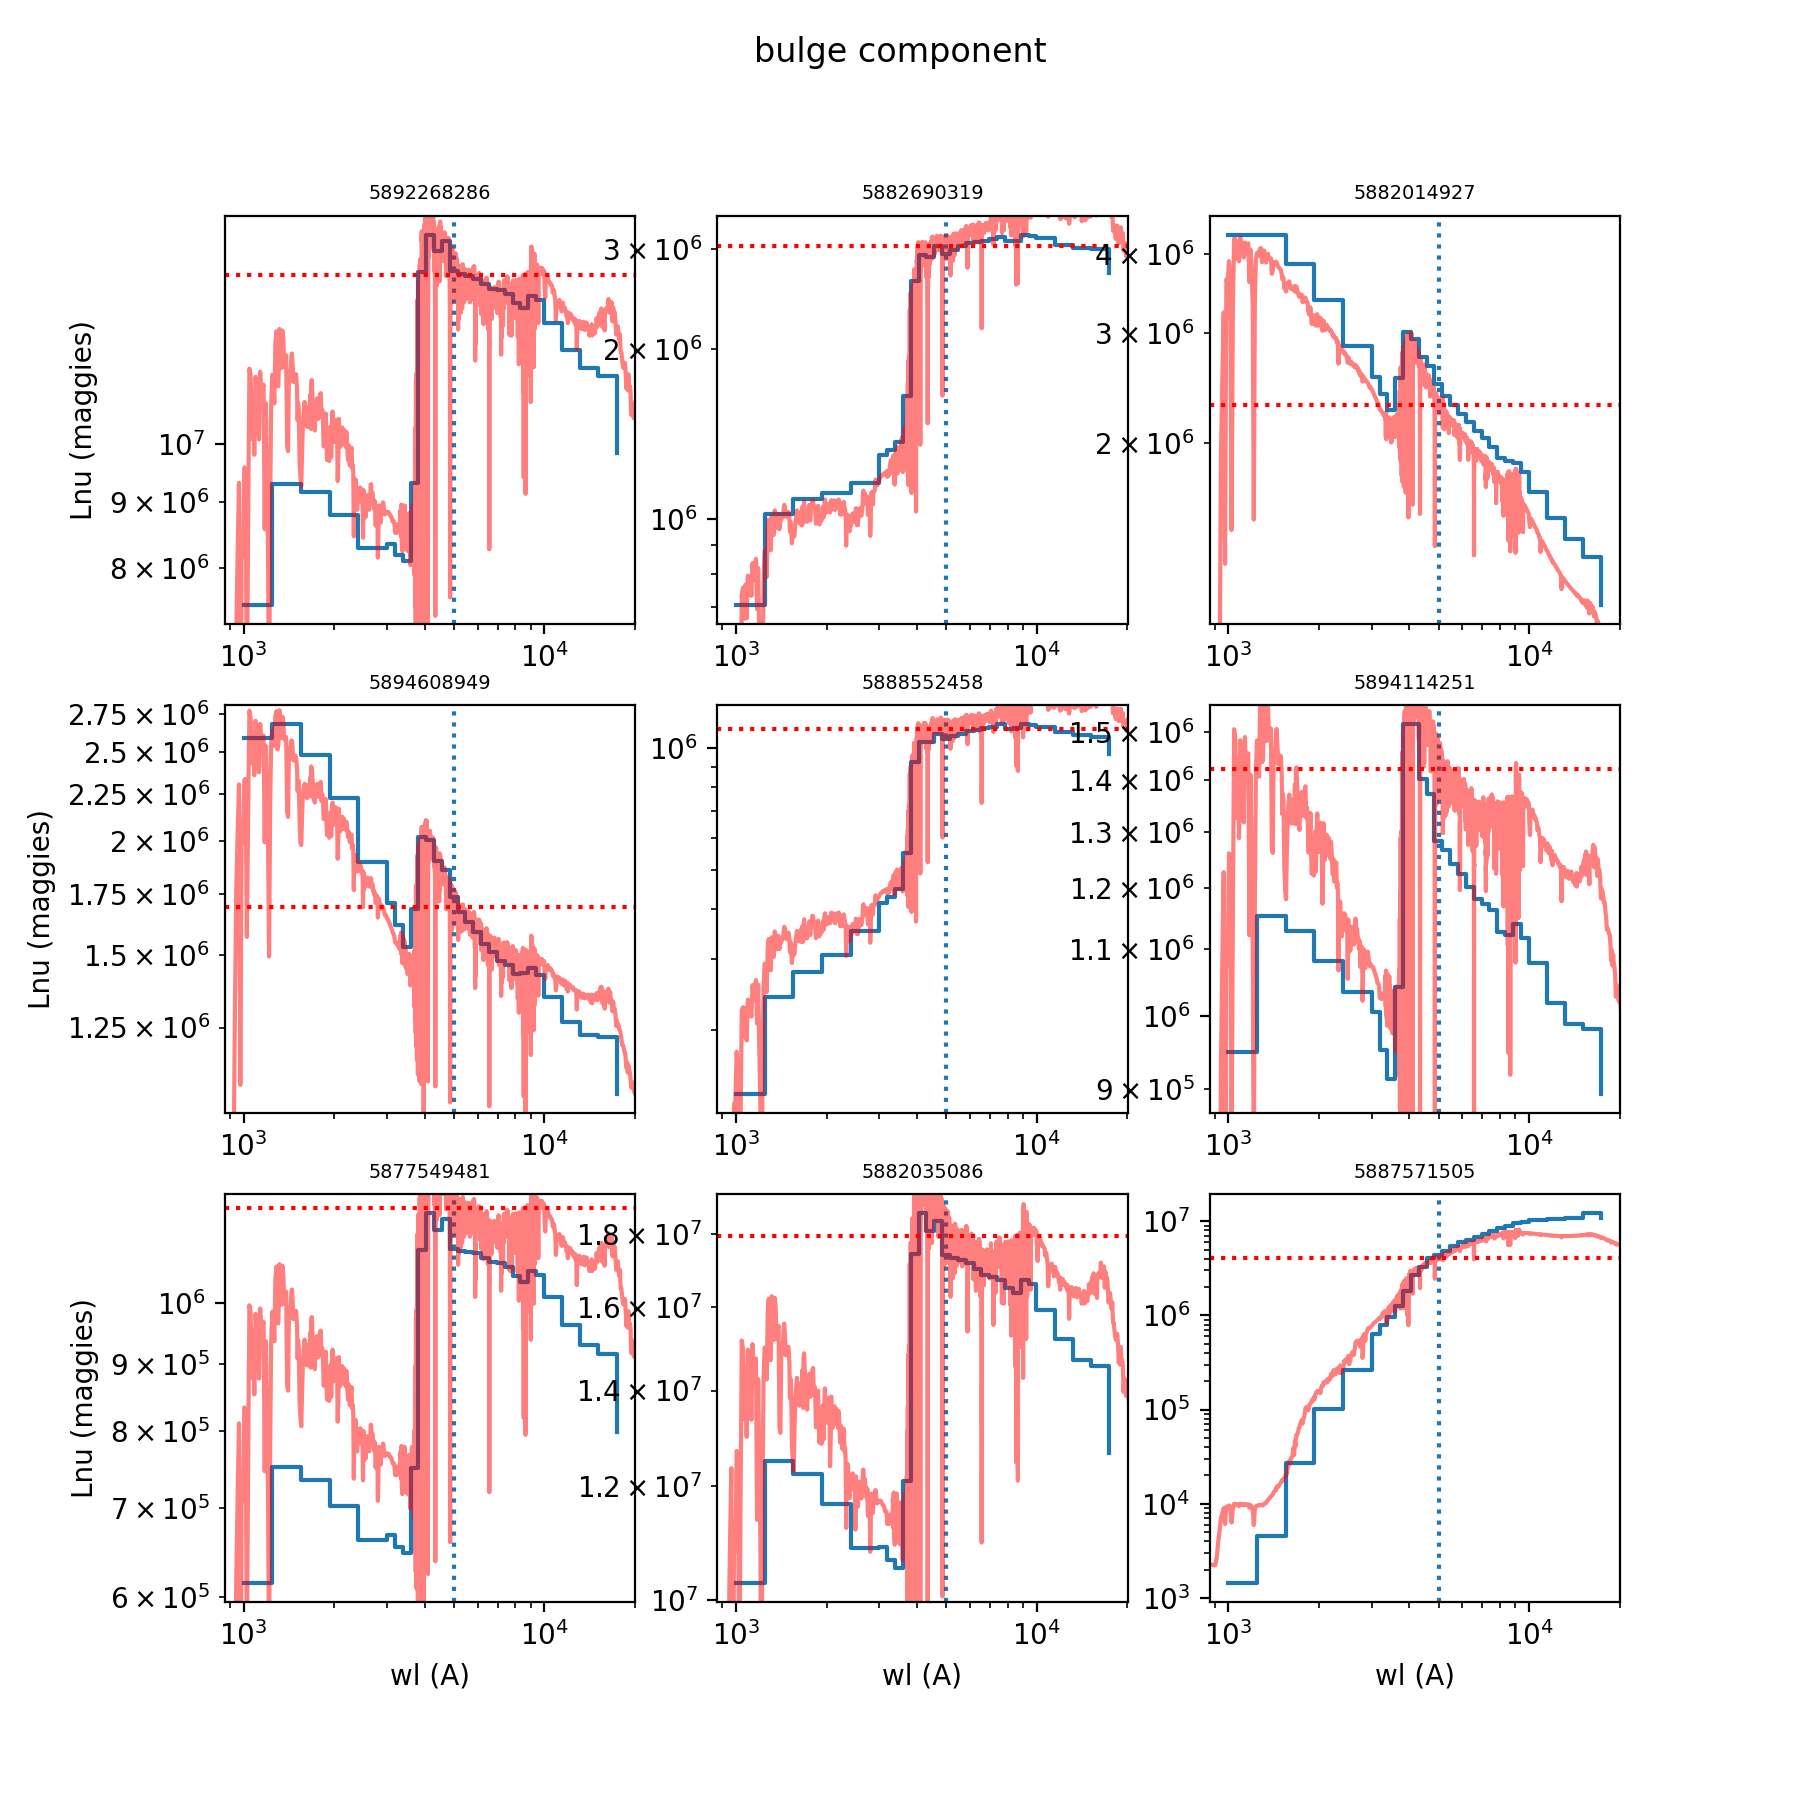

<ipython-input-14-697c3939ca0d>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=(0, 1, 0, 0.95))


In [14]:
one_Jy = 1e-26    # W/Hz/m**2
one_maggy = 4.3442e13   # W/Hz

plt.figure(figsize=(9, 9))
for i, iloc in enumerate(iloc_values, 1):
    row = df_summary.iloc[iloc]
    plt.subplot(3, 3, i)
    wl, Fnu = plot_tophat_sed(df_seds, row['gal_id'])
    if i in (7, 8, 9):
        plt.xlabel('wl (A)')
    if i in (1, 4, 7):
        plt.ylabel('Lnu (maggies)')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{row["gal_id"]}', fontsize='x-small')
    axis = plt.axis()
    plt.axvline(5000, linestyle=':')

    wl_nm, Flam_norm = np.genfromtxt(sed_file(row['orig_sed_file'])).transpose()
    wl_A = wl_nm*10
    Fnu_ref = 10**((row['orig_magnorm'] - 8.90)/(-2.5))*one_Jy
    Lnu_ref = (Fnu_ref*4*np.pi*mag_norm.dl(row['redshift'])**2)/one_maggy
    plt.axhline(Lnu_ref, linestyle=':', color='red')
    
    Fnu_arb = Flam_norm*wl_nm**2
    index = np.where(wl_nm <= 500)
    Lnu_sed = Lnu_ref*Fnu_arb/Fnu_arb[index[0][-1]]
    plt.plot(wl_A, Lnu_sed, color='red', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.axis(axis)
plt.tight_layout(rect=(0, 1, 0, 0.95))
plt.suptitle(f'{component_type.split("_")[0]} component');

In [15]:
sed_factory = GalaxyTopHatSEDFactory()

CPU times: user 6.41 s, sys: 12.1 s, total: 18.5 s
Wall time: 40 s


<IPython.core.display.Javascript object>


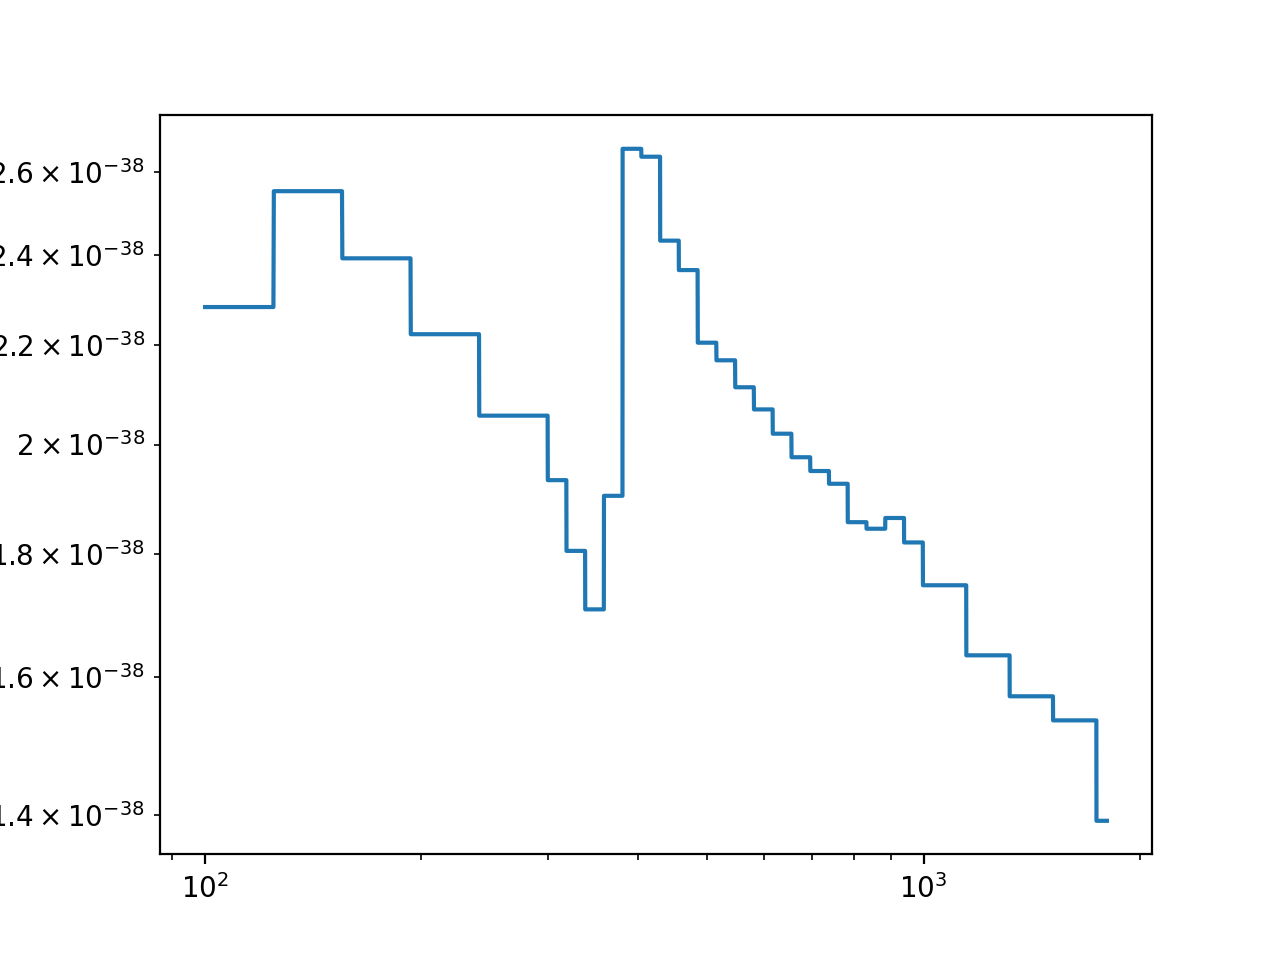

In [16]:
component_type = 'disk_no_host_extinction'
galaxy_id = 6879535821
healpix = 9684
%time sed = sed_factory.create(galaxy_id, healpix, component_type=component_type)

wls = np.linspace(100, 1800, 10000)
fnu = np.array([sed.fnu(wl) for wl in wls])
plt.figure()
plt.plot(wls, fnu)
plt.xscale('log')
plt.yscale('log')